<a href="https://colab.research.google.com/github/bonareri/Machine-Learning/blob/main/spotify_reviews_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of App Reviews

**Introduction**

- **Objective:** The goal of this project is to analyze app reviews and classify their sentiment as positive, neutral, or negative. This helps businesses understand user feedback and improve their products.
- **Dataset:** The dataset contains app reviews labeled with their corresponding sentiment. For this project, we used a sample of 500 reviews from a larger dataset.

## Import necessary libraries

In [136]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
#loading data
df = pd.read_csv('/content/reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [139]:
# dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


## 1. Preprocessing the Data:

### 1.1 Drop unnecessary columns and handle missing values

In [140]:
# Drop 'Time_submitted' and 'Reply' columns
df = df.drop(columns=['Time_submitted', 'Reply'])

# Check for any missing values
df.isnull().sum()

,0
Review,0
Rating,0
Total_thumbsup,0


### 1.2 Create a target column (Sentiment) based on the Rating column

- Positive sentiment can be assigned for ratings 4 and 5.
- Negative sentiment for ratings 1 and 2.
- Neutral sentiment for ratings 3.

In [141]:
# Create a new 'Sentiment' column based on 'Rating'
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment'] = df['Rating'].apply(map_sentiment)

### 1.3  Text Preprocessing (Cleaning the Reviews)

cleaning the reviews before feeding them into the model. This involves:

- Converting to lowercase: Helps standardize the text (e.g., "Great" and "great" are considered the same).
- Removing stopwords: Words like "the," "is," "in," which don’t add much meaning in sentiment analysis.
- Lemmatization: Converts words to their base form (e.g., "running" becomes "run").

In [142]:
df_500 = df.head(10000)
df_500.head()

,Review,Rating,Total_thumbsup,Sentiment
0,"Great music service, the audio is high quality...",5,2,positive
1,Please ignore previous negative rating. This a...,5,1,positive
2,"This pop-up ""Get the best Spotify experience o...",4,0,positive
3,Really buggy and terrible to use as of recently,1,1,negative
4,Dear Spotify why do I get songs that I didn't ...,1,1,negative


In [143]:
# Load the Spacy model
nlp = spacy.load('en_core_web_sm')

In [144]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Process text with Spacy
    doc = nlp(text)

    # Lemmatize and remove stopwords and punctuation
    cleaned_text = " ".join([token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_punct])

    return cleaned_text

In [145]:
# Apply the cleaning function to the 'Review' column
df_500['Cleaned_Review'] = df_500['Review'].apply(clean_text)

# Display the first few rows of the cleaned data
df_500.head()

<ipython-input-145-1eae9f6e8f08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Cleaned_Review'] = df_500['Review'].apply(clean_text)


,Review,Rating,Total_thumbsup,Sentiment,Cleaned_Review
0,"Great music service, the audio is high quality...",5,2,positive,great music service audio high quality app eas...
1,Please ignore previous negative rating. This a...,5,1,positive,ignore previous negative rating app super grea...
2,"This pop-up ""Get the best Spotify experience o...",4,0,positive,pop good spotify experience android 12 annoyin...
3,Really buggy and terrible to use as of recently,1,1,negative,buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,1,1,negative,dear spotify song playlist shuffle play


## 3. Feature Extraction Using Word2Vec

**Why I Chose Word2Vec:**

- **Semantic Understanding:** Unlike TF-IDF, which treats words independently, Word2Vec captures semantic relationships between words. For example, "good" and "great" would have similar embeddings, reflecting their related meanings.

- **Dimensionality Reduction:** Word2Vec generates dense vector representations (embeddings), reducing the computational burden while retaining meaningful information.

- **Contextual Relevance:** Word2Vec uses the context of a word in a sentence to determine its embedding. This is particularly useful for predicting neutral reviews, as subtle context often differentiates neutral from polar sentiments.

- **Efficient and Lightweight:** Compared to transformers like BERT, Word2Vec is computationally efficient, making it ideal for resource-constrained environments.

### Tokenization and Training the Word2Vec Model

In [158]:
tokenized_reviews = df_500['Cleaned_Review'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

### Embedding Function for Reviews

In [159]:
def embed_review(review, model, vector_size=100):
    words = review.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)


### Generating Embeddings for the Dataset

In [160]:
df_500['Embeddings'] = df_500['Cleaned_Review'].apply(lambda x: embed_review(x, word2vec_model))

<ipython-input-160-70d646b3bf51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Embeddings'] = df_500['Cleaned_Review'].apply(lambda x: embed_review(x, word2vec_model))


### Creating the Feature Matrix

In [161]:
X = np.vstack(df_500['Embeddings'])
y = df_500['Sentiment']

In [162]:
y

,Sentiment
0,positive
1,positive
2,positive
3,negative
4,negative
...,...
9995,neutral
9996,negative
9997,positive
9998,positive


## Sentiment Labels

Positive: Rating ≥ 4
Neutral: Rating = 3
Negative: Rating ≤ 2

In [163]:
# Define sentiment categories based on the rating
df_500['Sentiment'] = df_500['Rating'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

# Check the new sentiment column
df_500['Sentiment'].value_counts()

<ipython-input-163-1d027cafd6aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['Sentiment'] = df_500['Rating'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))


,count
Sentiment,
positive,5533
negative,3446
neutral,1021


### Visualize the Sentiment Analysis ResultsVisualize the Sentiment Analysis Results

### Sentiment Distribution

<ipython-input-148-8de15c80d8c4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


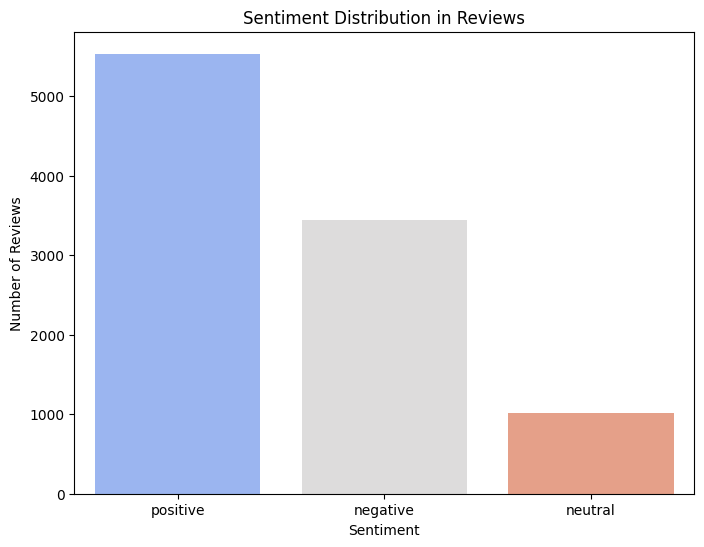

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each sentiment
sentiment_counts = df_500['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Distribution in Reviews')
plt.show()

### Rating Distribution

<ipython-input-149-984f64eb1af5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_500, x='Rating', palette='coolwarm')


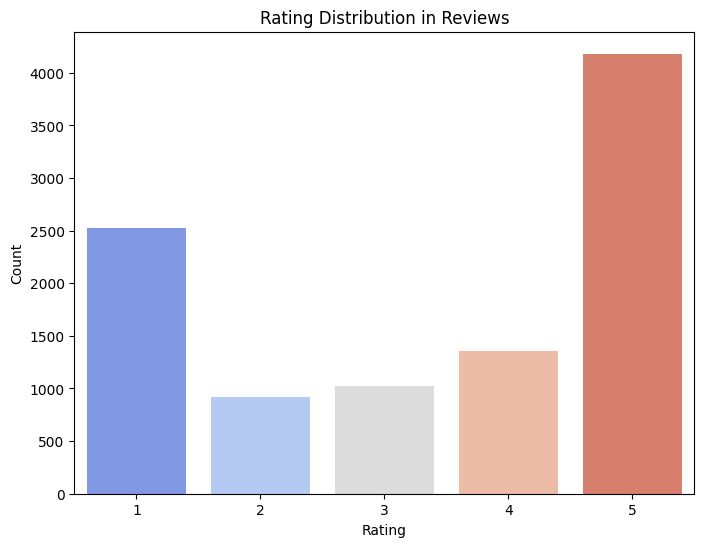

In [149]:
# Plot the rating distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df_500, x='Rating', palette='coolwarm')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution in Reviews')
plt.show()

### Visualizing Sentiment vs Rating

To get a better understanding of how the sentiments correlate with ratings, we can visualize sentiment in relation to the rating.

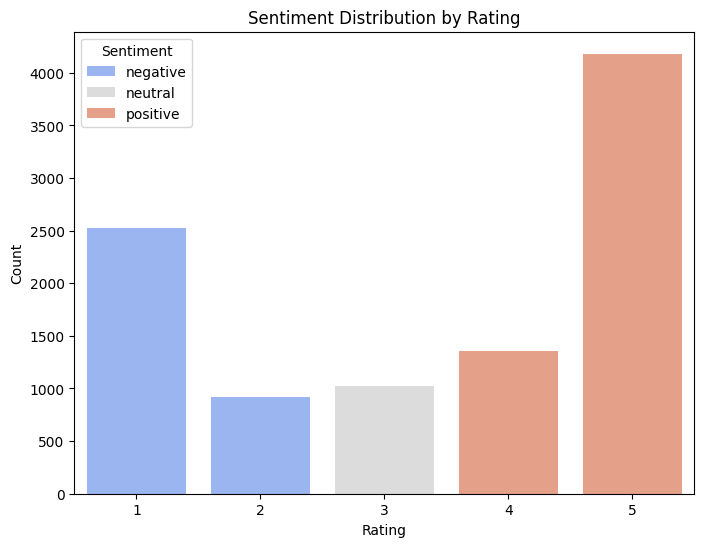

In [150]:
# Plot sentiment vs rating
plt.figure(figsize=(8, 6))
sns.countplot(data=df_500, x='Rating', hue='Sentiment', palette='coolwarm')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Rating')
plt.show()

### Wordcloud for Sentiment Analysis

In [151]:
from wordcloud import WordCloud

In [152]:
# Create a word cloud for each sentiment
positive_reviews = " ".join(df_500[df_500['Sentiment'] == 'positive']['Cleaned_Review'])
neutral_reviews = " ".join(df_500[df_500['Sentiment'] == 'neutral']['Cleaned_Review'])
negative_reviews = " ".join(df_500[df_500['Sentiment'] == 'negative']['Cleaned_Review'])

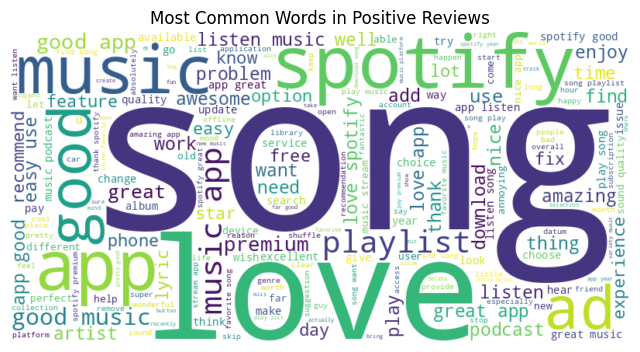

In [153]:
# Plot wordcloud for positive sentiment
plt.figure(figsize=(8, 6))
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews')
plt.axis('off')
plt.show()

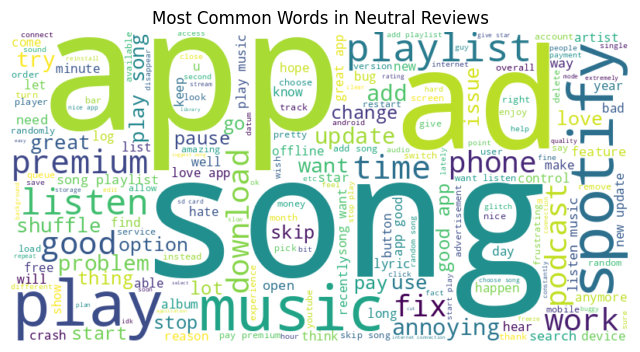

In [154]:
# Plot wordcloud for neutral sentiment
plt.figure(figsize=(8, 6))
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Neutral Reviews')
plt.axis('off')
plt.show()

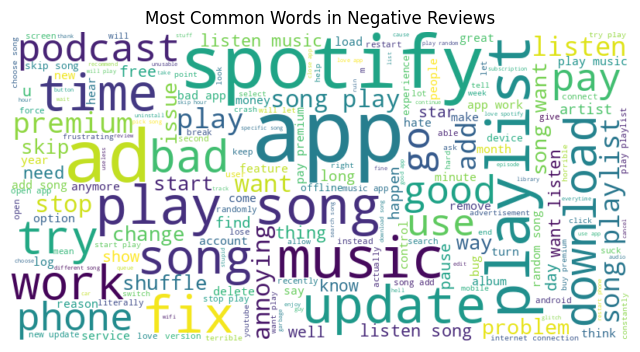

In [155]:
# Plot wordcloud for negative sentiment
plt.figure(figsize=(8, 6))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews')
plt.axis('off')
plt.show()

### Encode Sentiment Labels

In [165]:
from sklearn.preprocessing import LabelEncoder

# Encode the sentiment labels
label_encoder = LabelEncoder()
# Use .loc to ensure modification is done in place
df_500.loc[:, 'Sentiment_Encoded'] = label_encoder.fit_transform(df_500['Sentiment'])


# View encoded labels
print(label_encoder.classes_)  # ['negative', 'neutral', 'positive']

['negative' 'neutral' 'positive']


## Handling class imbalance

**Summary**

To address the class imbalance in sentiment analysis, I chose to adjust the class weights in the model rather than using oversampling techniques like SMOTE. Here's why:

- Resource Efficiency: Class weights modify the training process without increasing the dataset size, making it ideal for limited computational resources.
- Compatibility with Word2Vec: Adjusting class weights ensures the model learns from actual examples rather than generating synthetic embeddings, which might introduce noise.
- Effective for Neutral Reviews: Neutral reviews often have subtle language patterns that are better captured with real examples than with synthetic samples.



### Oversampling the Minority Classes

In [166]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_500[df_500['Sentiment'] == 'positive']
df_minority_neutral = df_500[df_500['Sentiment'] == 'neutral']
df_minority_negative = df_500[df_500['Sentiment'] == 'negative']

# Oversample minority classes
df_minority_neutral_oversampled = resample(df_minority_neutral,
                                           replace=True,
                                           n_samples=len(df_majority),
                                           random_state=42)
df_minority_negative_oversampled = resample(df_minority_negative,
                                            replace=True,
                                            n_samples=len(df_majority),
                                            random_state=42)

# Combine oversampled minority classes with majority class
df_balanced = pd.concat([df_majority, df_minority_neutral_oversampled, df_minority_negative_oversampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
print(df_balanced['Sentiment'].value_counts())

Sentiment
neutral     5533
positive    5533
negative    5533
Name: count, dtype: int64


## Prepare Data for Modeling

In [167]:
# Prepare feature matrix and target vector
X = np.vstack(df_balanced['Embeddings'])
y = df_balanced['Sentiment_Encoded']

## Train-Test Split

In [168]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Modelling

### RandomForestClassifier

In [170]:
# Train the classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluation Metrics

In [171]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.84      0.94      0.89      1106
     neutral       0.95      0.99      0.97      1107
    positive       0.96      0.80      0.87      1107

    accuracy                           0.91      3320
   macro avg       0.92      0.91      0.91      3320
weighted avg       0.92      0.91      0.91      3320



In [172]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 91.14%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

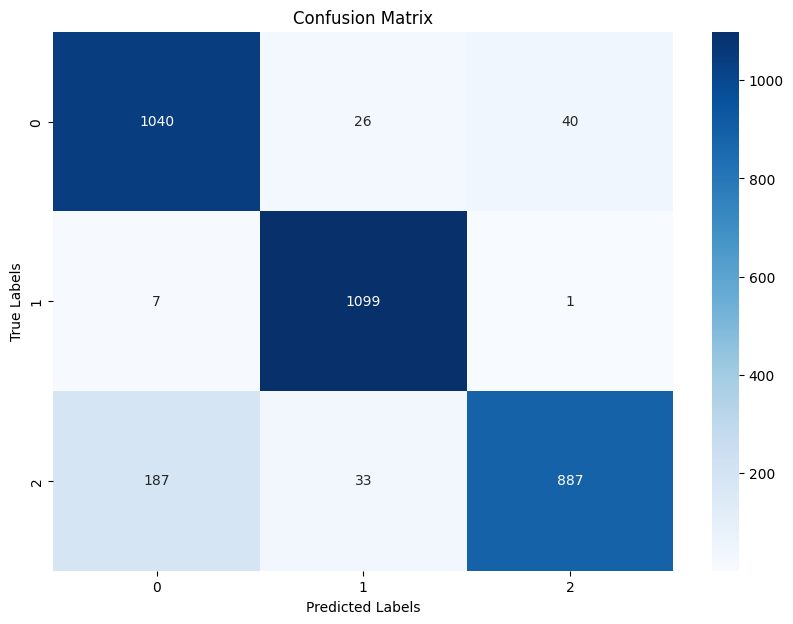

In [173]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

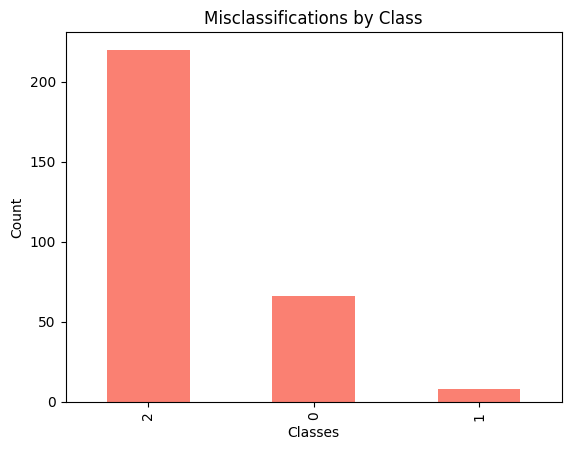

In [174]:
import pandas as pd

# Create a DataFrame for actual vs predicted labels
df_errors = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Filter the rows where prediction is incorrect
misclassified = df_errors[df_errors['Actual'] != df_errors['Predicted']]

# Plot the count of misclassifications by class
misclassified_counts = misclassified['Actual'].value_counts()
misclassified_counts.plot(kind='bar', color='salmon')
plt.title('Misclassifications by Class')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


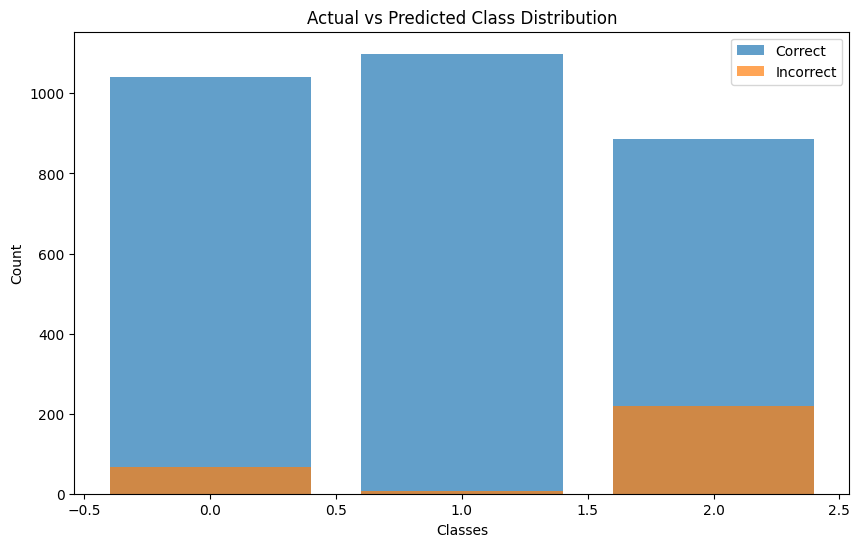

In [175]:
correct = df_errors[df_errors['Actual'] == df_errors['Predicted']]
correct_counts = correct['Actual'].value_counts()

# Plot for correct and incorrect classifications
plt.figure(figsize=(10, 6))
plt.bar(correct_counts.index, correct_counts.values, label="Correct", alpha=0.7)
plt.bar(misclassified_counts.index, misclassified_counts.values, label="Incorrect", alpha=0.7)
plt.title('Actual vs Predicted Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.legend()
plt.show()

In [176]:
# Extract the rows where predictions were incorrect
misclassified_instances = df_errors[df_errors['Actual'] != df_errors['Predicted']]

# Display the actual and predicted values for a few errors
print(misclassified_instances.head())

       Actual  Predicted
15200       2          0
8824        0          2
16067       2          0
7650        2          0
6351        0          2


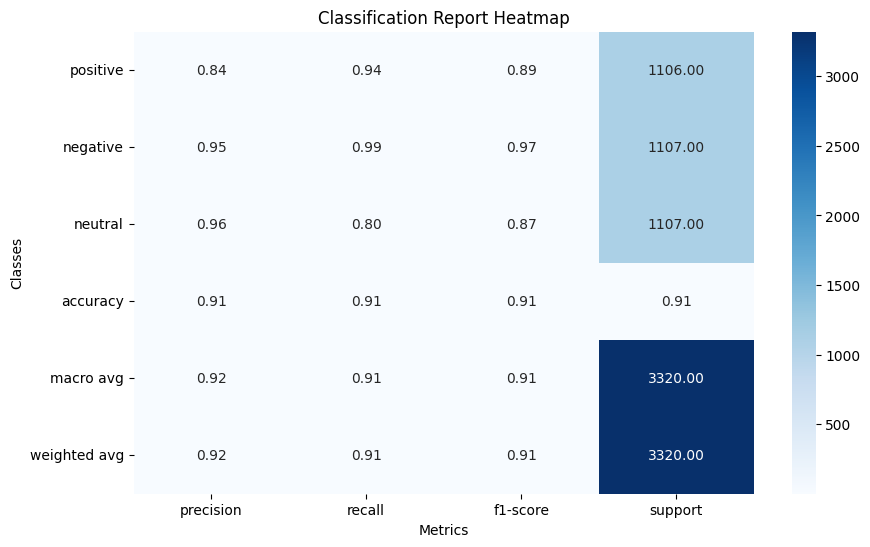

In [177]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=df_500.Sentiment.unique(), output_dict=True)


# Convert report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='Blues', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

## Predictions

In [182]:
# Example prediction on Spotify reviews
new_review = ["This app has great music selection, but it keeps freezing."]

# Clean the review using the same cleaning function
new_review_cleaned = [clean_text(review) for review in new_review]

# Tokenize the cleaned review and generate embeddings using Word2Vec
new_review_embedded = [embed_review(review, word2vec_model) for review in new_review_cleaned]

# Convert the embeddings into a numpy array (same as for the training data)
new_review_embedded = np.array(new_review_embedded)

# Ensure the feature matrix is in the same shape as the training data
new_review_embedded = np.vstack(new_review_embedded)

# Make a prediction using the trained model
prediction = model.predict(new_review_embedded)

# Define the label mapping (if needed)
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Output the prediction with a label
print(f"Predicted sentiment: {label_mapping[prediction[0]]}")  # This will print the predicted sentiment (positive, negative, neutral)

Predicted sentiment: positive


In [184]:
# Example prediction on a new Spotify review
new_review = ["The app keeps crashing and the playlist recommendations are awful."]

# Clean the review using the same cleaning function
new_review_cleaned = [clean_text(review) for review in new_review]

# Tokenize the cleaned review and generate embeddings using Word2Vec
new_review_embedded = [embed_review(review, word2vec_model) for review in new_review_cleaned]

# Convert the embeddings into a numpy array (same as for the training data)
new_review_embedded = np.array(new_review_embedded)

# Ensure the feature matrix is in the same shape as the training data
new_review_embedded = np.vstack(new_review_embedded)

# Make a prediction using the trained model
prediction = model.predict(new_review_embedded)

# Define the label mapping (if needed)
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Get the predicted sentiment label
predicted_sentiment = label_mapping[prediction[0]]

# Output the prediction with enhanced context
print(f"Review: {new_review[0]}")
print(f"Predicted sentiment: {predicted_sentiment} ({prediction[0]})")

Review: The app keeps crashing and the playlist recommendations are awful.
Predicted sentiment: negative (0)
